EDA -> Feature Engineering -> Modelling -> Model Validation

# EDA

In [470]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

%matplotlib inline

In [471]:
# test_features = pd.read_csv('test_set_features.csv')
raw_train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')


In [472]:
drop_columns = [
    'health_insurance'
    , 'employment_occupation'
    , 'employment_industry'
    , 'h1n1_concern'
    , 'h1n1_knowledge'
    , 'doctor_recc_h1n1'
    , 'opinion_h1n1_vacc_effective'
    , 'opinion_h1n1_risk'
    , 'opinion_h1n1_sick_from_vacc'
]

cleaned_train_features = raw_train_features.drop(columns=drop_columns)

In [473]:
survey_data = cleaned_train_features.merge(right=train_labels, how='inner', on='respondent_id')

In [474]:
survey_data.groupby(['sex'])['seasonal_vaccine'].sum()

sex
Female    7888
Male      4547
Name: seasonal_vaccine, dtype: int64

<AxesSubplot:xlabel='race'>

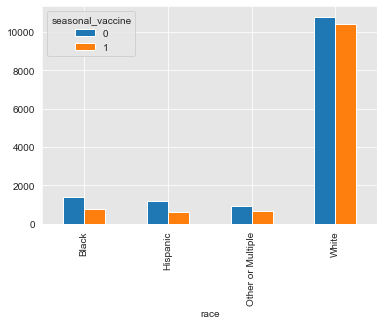

In [475]:
vaccine_by_race = survey_data.groupby(['race', 'seasonal_vaccine'])['seasonal_vaccine'].count()
vaccine_by_race.unstack().plot(kind='bar')

In [476]:
survey_data['hhs_geo_region'].value_counts()

lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64

<AxesSubplot:xlabel='age_group'>

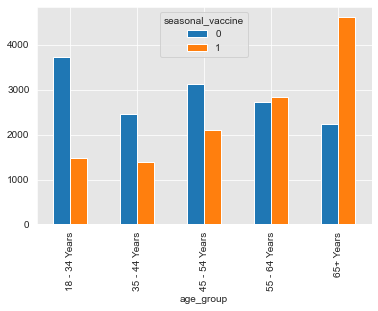

In [477]:
vaccine_by_eco_stats = survey_data.groupby(['age_group', 'seasonal_vaccine'])['seasonal_vaccine'].count()
vaccine_by_eco_stats.unstack().plot(kind='bar')

<AxesSubplot:xlabel='opinion_seas_vacc_effective'>

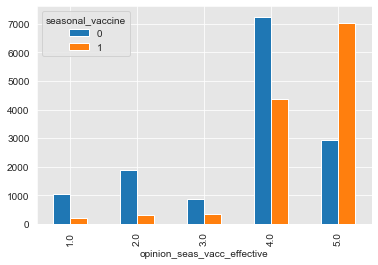

In [478]:
vaccine_by_opinion_seas_vacc_effective = survey_data.groupby(['opinion_seas_vacc_effective', 'seasonal_vaccine'])['seasonal_vaccine'].count()
vaccine_by_opinion_seas_vacc_effective.unstack().plot(kind='bar')

<AxesSubplot:xlabel='doctor_recc_seasonal'>

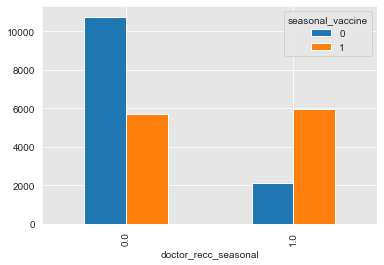

In [479]:
vaccine_by_doctor_recc_seasonal = survey_data.groupby(['doctor_recc_seasonal', 'seasonal_vaccine'])['seasonal_vaccine'].count()
vaccine_by_doctor_recc_seasonal.unstack().plot(kind='bar')

# Feature Engineering

In [480]:
from sklearn.model_selection import train_test_split

X = survey_data.drop(columns=['respondent_id','seasonal_vaccine', 'h1n1_vaccine'])
y = survey_data['seasonal_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [481]:
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# import numpy as np


# imp = SimpleImputer(strategy='most_frequent')
# ohe = OneHotEncoder(sparse=False)


# # ---- X_train ----
# # X_train SimpleImputer
# X_train_imp = pd.DataFrame(imp.fit_transform(X_train),
#                            index=X_train.index,
#                            columns=X.columns)

# # X_train OneHotEncoder
# X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_imp),
#                            index=X_train_imp.index,
#                            columns=np.hstack(ohe.categories_))
# X_train_ohe.columns = ohe.get_feature_names(X_train_imp.columns) # Set column names of the X_train ohe dataframe



# # ---- X_test ----
# # X_test SimpleImputer
# X_test_imp = pd.DataFrame(imp.transform(X_test),
#                           index=X_test.index,
#                           columns=X_test.columns)

# # X_test OneHotEncoder
# X_test_ohe = pd.DataFrame(ohe.transform(X_test_imp),
#                           index=X_test_imp.index,
#                           columns=np.hstack(ohe.categories_))
# X_test_ohe.columns = ohe.get_feature_names(X_test_imp.columns) # Set column names of the X_test ohe dataframe

# X_train_ohe



In [482]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import numpy as np


def get_imp(X, type='train'):

    if type == 'test':
        array = imp.transform(X)
    else:
        array = imp.fit_transform(X)

    X_imp = pd.DataFrame(array,
                         index=X.index,
                         columns=X.columns)
    
    return X_imp

def get_ohe(X, type='train'):

    if type == 'test':
        array = ohe.transform(X)
    else:
        array = ohe.fit_transform(X)

    X_ohe = pd.DataFrame(array,
                         index=X.index)
    X_ohe.columns = ohe.get_feature_names(X.columns)

    return X_ohe




imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse=False)

X_train_imp = get_imp(X_train, type='train')
X_train_imp_ohe = get_ohe(X_train_imp, type='train')
X_test_imp = get_imp(X_test, type='test')
X_test_imp_ohe = get_ohe(X_test_imp, type='test')


# Baseline Modelling: Logistic Regression

In [483]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=1)
model_log = logreg.fit(X_train_imp_ohe, y_train)
model_log

LogisticRegression(random_state=1)

# Baseline Model Validation: Residuals and Confusion Matrix

Accuracy -> Confusion Matrix -> ROC/AUC Curve -> DecisionTreeClassifier


In [489]:
class ModelValidation(metaclass=type):

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        y_train_pred = logreg.predict(X_train)
        y_test_pred = logreg.predict(X_test)

        y_train_resid = np.abs(y_train - y_train_pred)
        y_test_resid = np.abs(y_test - y_test_pred)
        
        self.train_accuracy = pd.Series(y_train_resid).value_counts(normalize=True)[0]
        self.test_accuracy = pd.Series(y_test_resid).value_counts(normalize=True)[0]

    def plot_train_matrix(self):
        return plot_confusion_matrix(logreg, self.X_train, self.y_train)

    def plot_test_matrix(self):
        return plot_confusion_matrix(logreg, self.X_test, self.y_test)

    def plot_auc(self):
        y_score = logreg.fit(self.X_train, self.y_train).decision_function(self.X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)

        print('AUC: {}'.format(auc(fpr, tpr)))

        # Seaborn's beautiful styling
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

        print('AUC: {}'.format(auc(fpr, tpr)))
        plt.figure(figsize=(10, 8))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        

mv = ModelValidation(X_train_imp_ohe, X_test_imp_ohe, y_train, y_test)



In [ ]:
# def get_y_pred(X_transformed, y):
#     y_pred = logreg.predict(X_transformed)
#     residuals = np.abs(y - y_pred)
#     # print(pd.Series(residuals, name="Residuals (Counts)").value_counts())
#     # print()
#     print(f"Accuracy: {pd.Series(residuals, name='Accuracy').value_counts(normalize=True)[0]}")

#     return y_pred

In [ ]:
# y_train_pred = get_y_pred(X_train_imp_ohe, y_train)

In [ ]:
# y_test_pred = get_y_pred(X_test_imp_ohe, y_test)

In [ ]:
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

# cm = confusion_matrix(y_test, y_test_pred)

# plot_confusion_matrix(logreg, X_test_imp_ohe, y_test)
# print(classification_report(y_test, y_test_pred))

# Baseline Model Validation: Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

X_imp = get_imp(X)
X_imp_ohe = get_ohe(X_imp)

cross_val_score(logreg, X_imp_ohe, y, cv=5)

array([0.77330588, 0.7768626 , 0.77476128, 0.78318667, 0.77719528])

# Baseline Model Validation: ROC and AUC curve

AUC: 0.8602374864793138
AUC: 0.8602374864793138


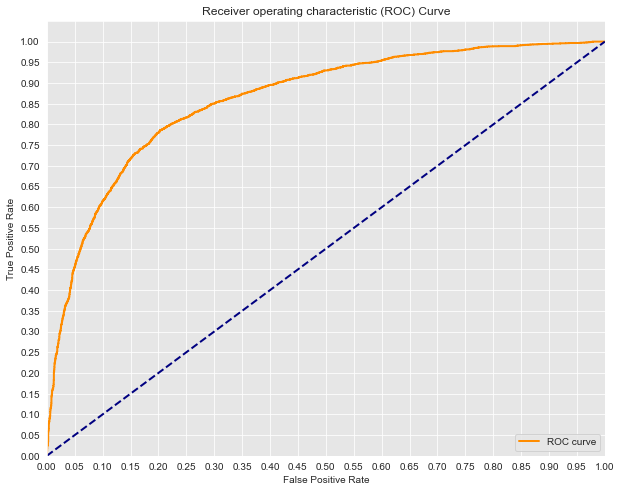

In [ ]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

# y_score = logreg.fit(X_train_imp_ohe, y_train).decision_function(X_test_imp_ohe)
# fpr, tpr, thresholds = roc_curve(y_test, y_score)

# print('AUC: {}'.format(auc(fpr, tpr)))

# # Seaborn's beautiful styling
# sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# print('AUC: {}'.format(auc(fpr, tpr)))
# plt.figure(figsize=(10, 8))
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve')
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.yticks([i/20.0 for i in range(21)])
# plt.xticks([i/20.0 for i in range(21)])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(criterion='entropy', max_depth=12)

clf.fit(X_train_ohe, y_train)

dict = {}
for name, importance in zip(X_train_ohe.columns, clf.feature_importances_):
    dict[name] = importance

sorted_dict = sorted(dict.items(), key=lambda x:x[1], reverse=True)
gini_coeff = pd.DataFrame(sorted_dict)
gini_coeff.head()
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize= (3,3), dpi=300)
# tree.plot_tree(clf,
#                feature_names=X_train_ohe.columns,
#                class_names=np.unique(y).astype('str'),
#                filled=True)

# plt.show()

,0,1
0,opinion_seas_vacc_effective_5.0,0.201974
1,doctor_recc_seasonal_1.0,0.149251
2,opinion_seas_risk_1.0,0.063691
3,age_group_65+ Years,0.050966
4,opinion_seas_risk_2.0,0.039814


In [ ]:
relevant_cols = ['opinion_seas_vacc_effective_5.0', 'doctor_recc_seasonal_0.0', 'opinion_seas_risk_1.0', 'age_group_65+ Years', 'doctor_recc_seasonal_1.0']
relevant_features = X_train_ohe[relevant_cols]
relevant_features_test = X_test_ohe[relevant_cols]

logreg = LogisticRegression(random_state=1)
model_log = logreg.fit(relevant_features, y_train)
model_log

LogisticRegression(random_state=1)